# Assigment 1: Regional crop yield prediction

In [1]:
from pathlib import Path
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
from scipy import stats
from math import sqrt
from sklearn.neighbors import KNeighborsRegressor
from statistics import mean

In [2]:
seed=42 
np.random.seed(seed)

In [3]:
import os
if 'yield_data' not in os.listdir():
    !git clone https://gist.github.com/3206e24244286dd25efd9e8bb39f079e.git yield_data

## Data visualization

### Exercise 1: Read the dataset, and visualy explore it

Load both the training and test datasets for potato, and then answer the questions that follow.

In [4]:
train = pd.read_csv("yield_data/potato_NL_train.csv", sep=",")
test  = pd.read_csv("yield_data/potato_NL_test.csv",  sep=",")

>#### Question 1.1
> Plot the histogram for the target variable (`YIELD`) for both the training and test datasets.

C:\Users\mdomi\AppData\Local\Temp\ipykernel_18204\2650363627.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


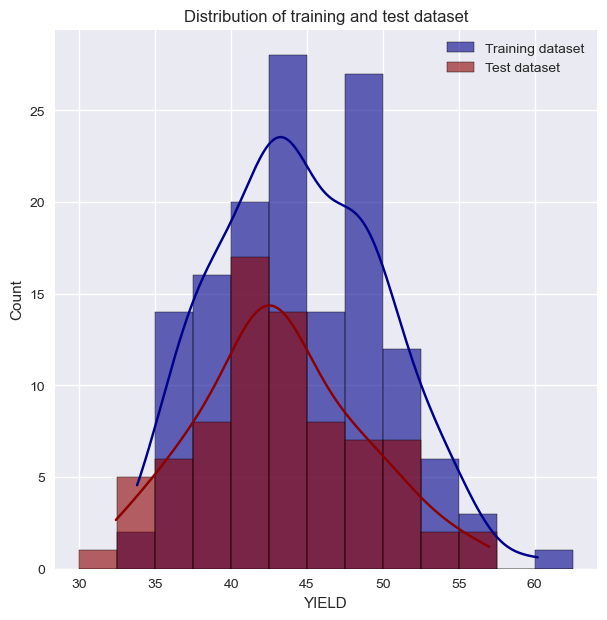

In [5]:
plt.style.use('seaborn')

fig, ax = plt.subplots(1, figsize = (7,7))

sns.histplot(train.YIELD,
             kde = True,
             ax = ax,
             bins = np.arange(30, 65, 2.5),
             label = 'Training dataset',
             alpha = 0.6,
             color = 'darkblue'
            )
sns.histplot(test.YIELD,
             kde = True,
             ax = ax,
             bins = np.arange(30, 65, 2.5),
             label = 'Test dataset',
             alpha = 0.6,
             color = 'darkred'
            )
plt.title('Distribution of training and test dataset')
plt.legend()

>    - Add a comment on comparing the two plots.

- The histogram shows that both training and test datasets have a very similar distribution, that is in fact close to be a normal distribution with a mean near 44 and a standard deviation near 5.
- Also, looking at the total count per dataset, we can notice that the training dataset (1999 - 2011) is larger than the test dataset (2012 - 2018). Logically, since we train the models with a larger dataset than the one we use to test them.

> #### Question 1.2
> Calculate summary statistics for potato yields, in both training and test split.

In [6]:
train.describe()

,FYEAR,SM_WHC,maxWLIM_YBp2,maxTWCp2,maxWLAIp2,maxWLIM_YBp4,maxWLIM_YSp4,maxTWCp4,maxWLAIp4,avgRSMp2,...,avgTAVGp1,avgPRECp1,avgTAVGp2,avgCWBp2,avgPRECp3,avgCWBp4,avgPRECp5,avgFAPARp2,avgFAPARp4,YIELD
count,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,...,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,2005.000000,0.173636,1764.102238,2.781538,2.569441,14413.999510,10312.435804,24.316783,5.383497,81.053776,...,12.375315,1.471748,13.331608,-1.312727,1.883427,-0.906154,2.289441,0.550000,0.671469,44.497902
std,3.754809,0.042202,1000.388492,1.533714,1.362440,3121.550964,2953.762361,4.020963,0.569246,20.714677,...,1.405125,0.589450,1.105281,0.818611,0.762960,0.702593,1.115108,0.068987,0.043378,5.386753
min,1999.000000,0.120000,278.800000,0.400000,0.350000,7141.320000,3892.940000,12.580000,3.720000,5.780000,...,9.220000,0.330000,10.240000,-3.350000,0.550000,-2.700000,0.120000,0.350000,0.580000,33.800000
25%,2002.000000,0.150000,905.220000,1.420000,1.270000,12229.225000,8123.700000,21.445000,5.040000,71.705000,...,11.590000,1.035000,12.605000,-1.705000,1.320000,-1.275000,1.550000,0.510000,0.640000,40.550000
50%,2005.000000,0.160000,1646.840000,2.790000,2.520000,14776.960000,10749.310000,24.850000,5.430000,82.440000,...,12.440000,1.430000,13.440000,-1.300000,1.820000,-0.910000,2.020000,0.550000,0.660000,44.000000
75%,2008.000000,0.220000,2295.380000,3.465000,3.455000,16744.445000,12479.730000,27.600000,5.775000,90.885000,...,13.380000,1.805000,14.125000,-0.835000,2.455000,-0.520000,2.765000,0.595000,0.690000,48.300000
max,2011.000000,0.270000,5048.430000,8.020000,5.830000,19542.020000,15359.520000,30.700000,6.500000,167.640000,...,15.600000,3.260000,16.490000,0.640000,3.740000,0.910000,5.820000,0.730000,0.780000,60.200000


In [7]:
test.describe()

,FYEAR,SM_WHC,maxWLIM_YBp2,maxTWCp2,maxWLAIp2,maxWLIM_YBp4,maxWLIM_YSp4,maxTWCp4,maxWLAIp4,avgRSMp2,...,avgTAVGp1,avgPRECp1,avgTAVGp2,avgCWBp2,avgPRECp3,avgCWBp4,avgPRECp5,avgFAPARp2,avgFAPARp4,YIELD
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,...,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,2015.000000,0.173636,1622.414675,2.762338,2.458701,13222.334935,9422.499870,23.115195,5.029610,79.662338,...,11.833896,1.757273,13.339740,-1.356104,1.852338,-1.193766,2.447922,0.568571,0.672597,43.232468
std,2.013115,0.042330,914.330464,1.527208,1.313332,3979.252481,3566.537023,6.074782,0.764785,24.465992,...,1.279513,0.635038,1.456449,1.005047,0.719733,0.838151,1.274793,0.056678,0.055284,5.426529
min,2012.000000,0.120000,211.110000,0.340000,0.390000,4503.140000,2196.660000,8.790000,3.270000,10.320000,...,8.270000,0.800000,10.900000,-3.040000,0.880000,-3.510000,0.370000,0.450000,0.540000,32.400000
25%,2013.000000,0.150000,1070.850000,1.800000,1.600000,10313.600000,6723.500000,19.400000,4.460000,70.090000,...,11.050000,1.280000,11.930000,-2.000000,1.230000,-1.470000,1.550000,0.530000,0.640000,39.400000
50%,2015.000000,0.160000,1336.130000,2.240000,2.150000,14371.560000,10341.930000,24.550000,5.170000,86.140000,...,11.610000,1.690000,13.370000,-1.550000,1.660000,-0.950000,2.230000,0.560000,0.670000,42.700000
75%,2017.000000,0.220000,2255.930000,3.620000,3.480000,16330.700000,12506.290000,27.310000,5.670000,97.330000,...,12.850000,2.070000,14.420000,-0.740000,2.570000,-0.650000,3.370000,0.620000,0.700000,46.400000
max,2018.000000,0.270000,4596.500000,7.070000,6.040000,19491.210000,14661.650000,32.160000,6.090000,119.880000,...,14.390000,3.370000,16.610000,1.230000,3.590000,0.210000,6.370000,0.680000,0.790000,57.000000


Not great for visualizing the results so we created some violin plots.

In [8]:
# Merge both datasets into a single dataframe
full = pd.concat([train, test]).reset_index(drop = True)

# Add a column 'set' with label train or test
full['set'] = np.ones(len(full))
full['set'].iloc[:len(train)] = 'train'
full['set'].iloc[len(train):] = 'test'
full[full['set']=='train'].describe()

C:\Users\mdomi\AppData\Local\Temp\ipykernel_18204\2618411572.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full['set'].iloc[:len(train)] = 'train'


,FYEAR,SM_WHC,maxWLIM_YBp2,maxTWCp2,maxWLAIp2,maxWLIM_YBp4,maxWLIM_YSp4,maxTWCp4,maxWLAIp4,avgRSMp2,...,avgTAVGp1,avgPRECp1,avgTAVGp2,avgCWBp2,avgPRECp3,avgCWBp4,avgPRECp5,avgFAPARp2,avgFAPARp4,YIELD
count,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,...,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,2005.000000,0.173636,1764.102238,2.781538,2.569441,14413.999510,10312.435804,24.316783,5.383497,81.053776,...,12.375315,1.471748,13.331608,-1.312727,1.883427,-0.906154,2.289441,0.550000,0.671469,44.497902
std,3.754809,0.042202,1000.388492,1.533714,1.362440,3121.550964,2953.762361,4.020963,0.569246,20.714677,...,1.405125,0.589450,1.105281,0.818611,0.762960,0.702593,1.115108,0.068987,0.043378,5.386753
min,1999.000000,0.120000,278.800000,0.400000,0.350000,7141.320000,3892.940000,12.580000,3.720000,5.780000,...,9.220000,0.330000,10.240000,-3.350000,0.550000,-2.700000,0.120000,0.350000,0.580000,33.800000
25%,2002.000000,0.150000,905.220000,1.420000,1.270000,12229.225000,8123.700000,21.445000,5.040000,71.705000,...,11.590000,1.035000,12.605000,-1.705000,1.320000,-1.275000,1.550000,0.510000,0.640000,40.550000
50%,2005.000000,0.160000,1646.840000,2.790000,2.520000,14776.960000,10749.310000,24.850000,5.430000,82.440000,...,12.440000,1.430000,13.440000,-1.300000,1.820000,-0.910000,2.020000,0.550000,0.660000,44.000000
75%,2008.000000,0.220000,2295.380000,3.465000,3.455000,16744.445000,12479.730000,27.600000,5.775000,90.885000,...,13.380000,1.805000,14.125000,-0.835000,2.455000,-0.520000,2.765000,0.595000,0.690000,48.300000
max,2011.000000,0.270000,5048.430000,8.020000,5.830000,19542.020000,15359.520000,30.700000,6.500000,167.640000,...,15.600000,3.260000,16.490000,0.640000,3.740000,0.910000,5.820000,0.730000,0.780000,60.200000


Text(0.5, 1.02, 'Violinplot visualization of predictors')

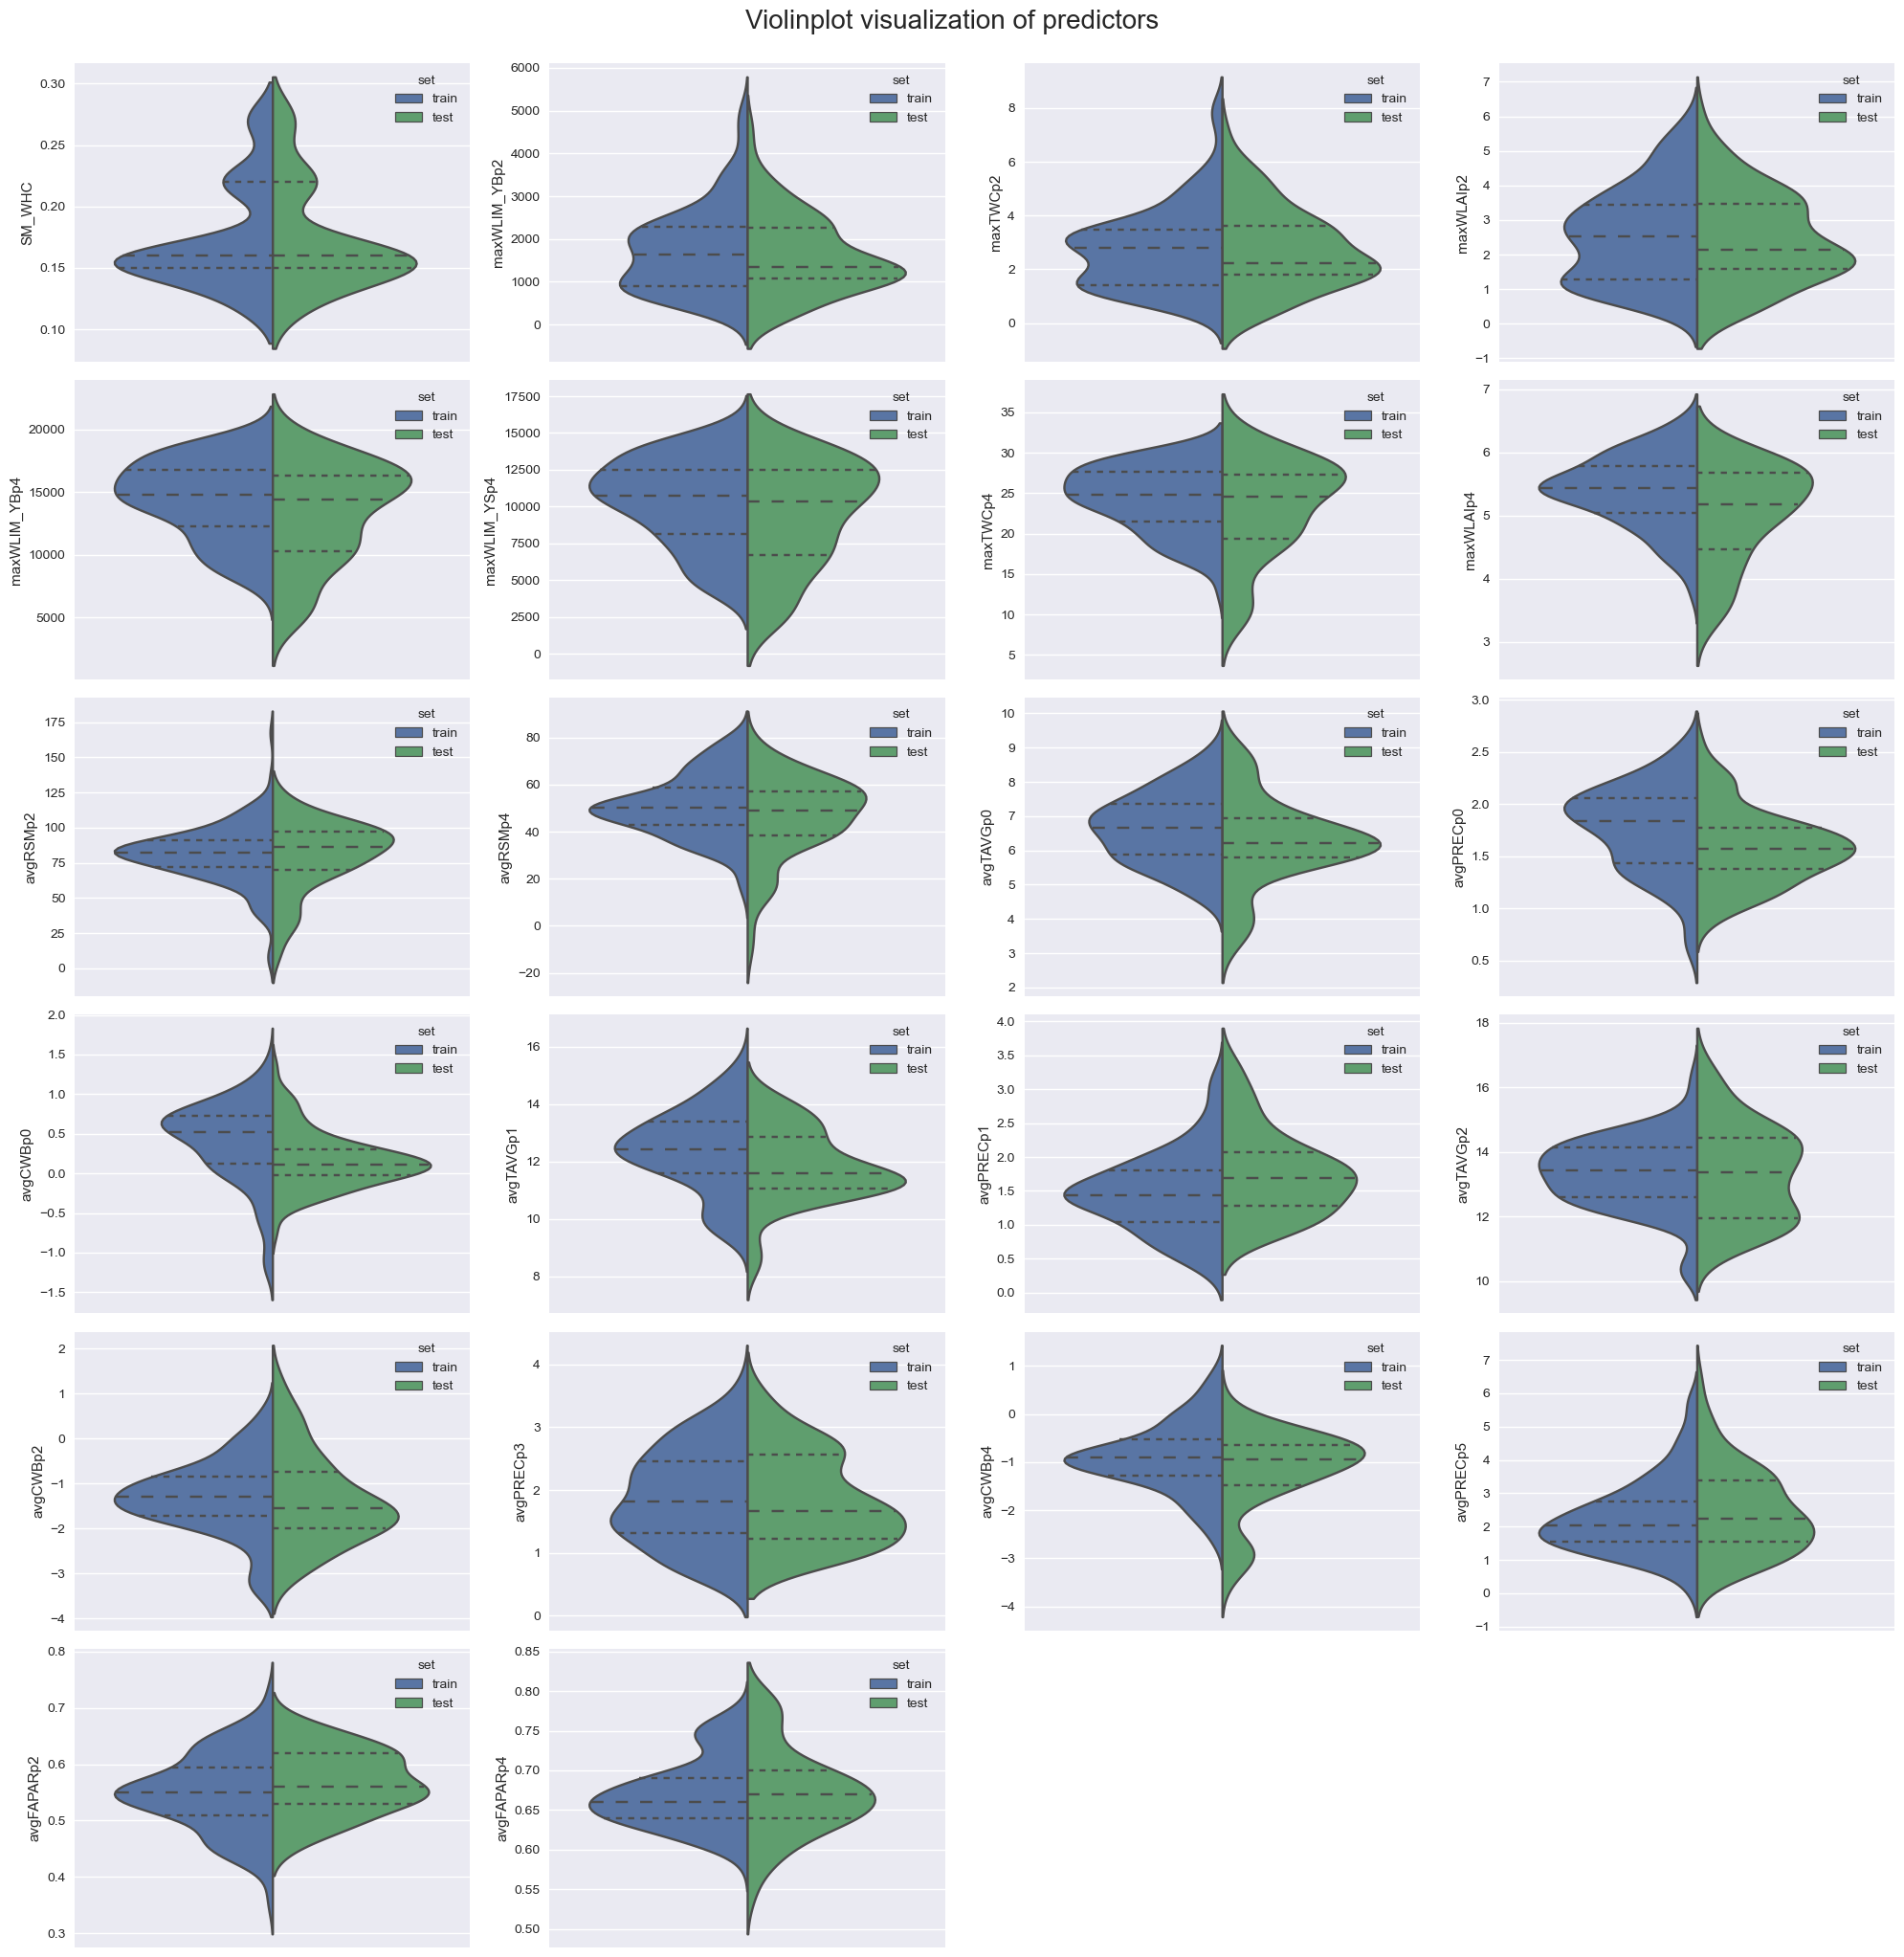

In [9]:
fig = plt.figure(figsize = (20,20))
for i in range(22):
    ax = plt.subplot(6,4,i+1)
    sns.violinplot(data = full,
                   x=np.ones(len(full)),
                   y = full.columns[i+2],
                   hue = 'set',
                   inner = 'quartile',
                   scale = 'area',
                   split = True)
    ax.set_xticklabels([''])
    
plt.tight_layout()
plt.suptitle('Violinplot visualization of predictors', fontsize = 20, y = 1.02)

In [10]:
for i in range(len(train.columns)-1):
    print('Shapiro–Wilk p-value:')
    print(train.columns[i+1],' train :', round(stats.shapiro(train.iloc[:,i+1]).pvalue, 5), 'Gaussian:', stats.shapiro(train.iloc[:,i+1]).pvalue > 0.05)
    print(test.columns[i+1],'test :', round(stats.shapiro(test.iloc[:,i+1]).pvalue, 5), 'Gaussian:', stats.shapiro(test.iloc[:,i+1]).pvalue > 0.05)
    print('----------------------------------------------------')

Shapiro–Wilk p-value:
FYEAR  train : 1e-05 Gaussian: False
FYEAR test : 0.0001 Gaussian: False
----------------------------------------------------
Shapiro–Wilk p-value:
SM_WHC  train : 0.0 Gaussian: False
SM_WHC test : 0.0 Gaussian: False
----------------------------------------------------
Shapiro–Wilk p-value:
maxWLIM_YBp2  train : 0.0 Gaussian: False
maxWLIM_YBp2 test : 0.00264 Gaussian: False
----------------------------------------------------
Shapiro–Wilk p-value:
maxTWCp2  train : 0.0 Gaussian: False
maxTWCp2 test : 0.01596 Gaussian: False
----------------------------------------------------
Shapiro–Wilk p-value:
maxWLAIp2  train : 0.00014 Gaussian: False
maxWLAIp2 test : 0.02572 Gaussian: False
----------------------------------------------------
Shapiro–Wilk p-value:
maxWLIM_YBp4  train : 0.00029 Gaussian: False
maxWLIM_YBp4 test : 0.0011 Gaussian: False
----------------------------------------------------
Shapiro–Wilk p-value:
maxWLIM_YSp4  train : 0.0002 Gaussian: False
max

>    - Interprete the summary statistics.

Looking at the summary we can notice that the entire dataset contains 220 observations and 22 features (Year, and yield not included). the features have different units and are not scaled. 

From the violin plots we can also notice that the mean values differs from the train and test data set for most of the features. Because of the last, could be a good idea to standardize the test data set using the train dataset mean and standard deviation.

Also from the violin plots, we can guess that the datasets have not a normal distribution. That's why we run a Shapiro Wilks test in order to know if the data is or is not normally distributed. To interpret this test we can check the p-value. The null hypothesis is that the data is normally distributed, if we reject the null hypothesis (p-value $<$ 0.5) we can know that the data is not normally distributed. Logarithmic or polynomial transformations could be applied to these variables to normalize them.

Looking at Shapiro Wilk test outputs we notice that most of the variables shows a p-value smaller than 0.5 so they are not normally distributed. Because of this, could be a good approach to standardize the data.

> #### Question 1.3 (Optional) 
>
> Plot a boxplot diagram of yields as a function of year for both training and test data.

C:\Users\mdomi\AppData\Local\Temp\ipykernel_18204\3603070119.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(full.FYEAR.unique(),


Text(0.5, 0.98, 'YIELD behaviour over time')

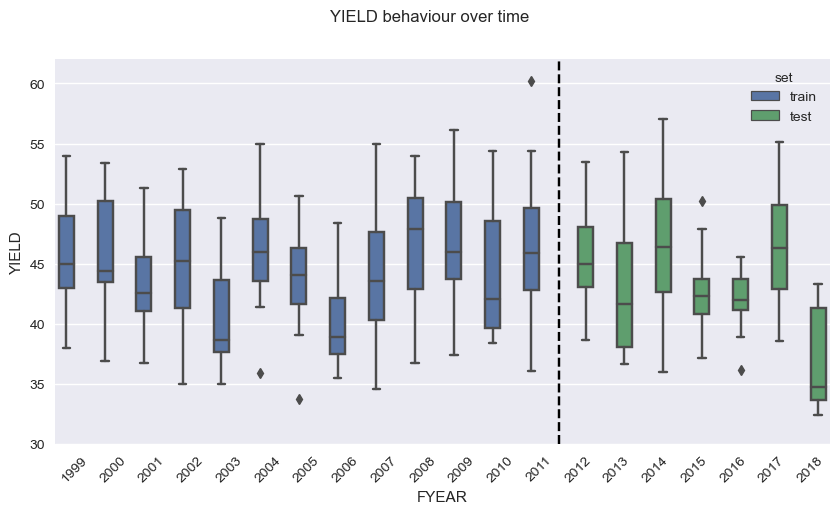

In [11]:
fig, ax = plt.subplots(1,1,figsize = (10,5))

ax.set_ylim(30,62)
ax.set_xticklabels(full.FYEAR.unique(),
                   rotation = 45)


sns.boxplot(data = full,
            x = 'FYEAR',
            y = 'YIELD',
            hue = 'set',
            ax = ax,
           )

plt.axvline(12.5, ls='--', c = 'k')

plt.suptitle('YIELD behaviour over time')

>  - What do you derive from this plot?

YIELD has remained relatively constant over the years with some particular bad years such as 2003, 2006 and 2018.

> #### Question 1.4. 
> Visually inspect the relationship using scatterplots, between `YIELD` and:  
>  
>   a. average FAPAR in periods p2 and p4, i.e. `avgFAPARp2`, `avgFAPARp4`.  

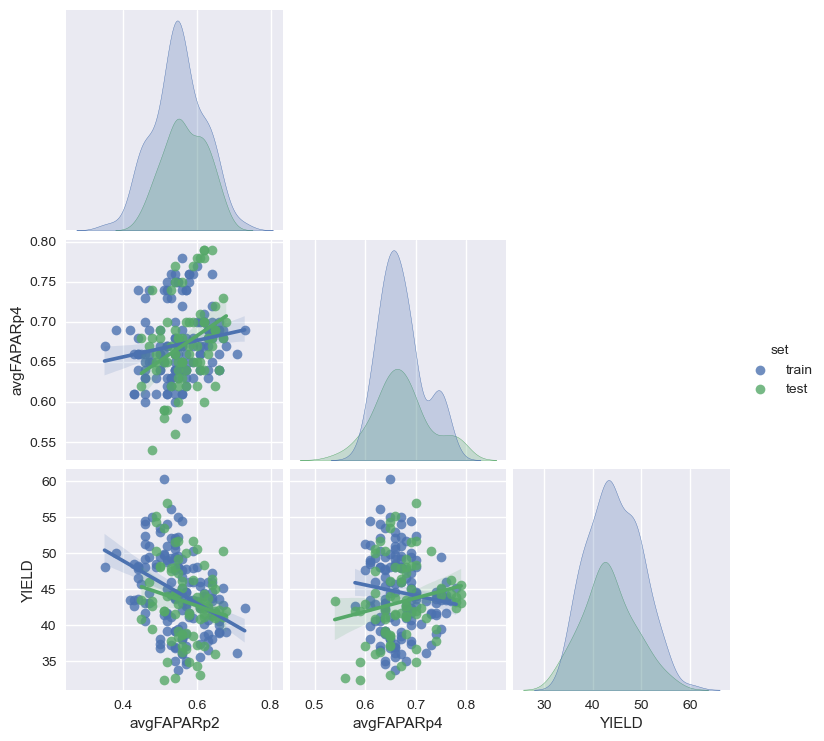

In [12]:
sns.pairplot(data = full.loc[:,['avgFAPARp2','avgFAPARp4','YIELD','set']],
             hue = 'set',
             kind = 'reg',
             corner = True)

>   b. average precipitation in periods p0, p3 and p5, i.e. `avgPRECp0`, `avgPRECp3`, `avgPRECp5`.

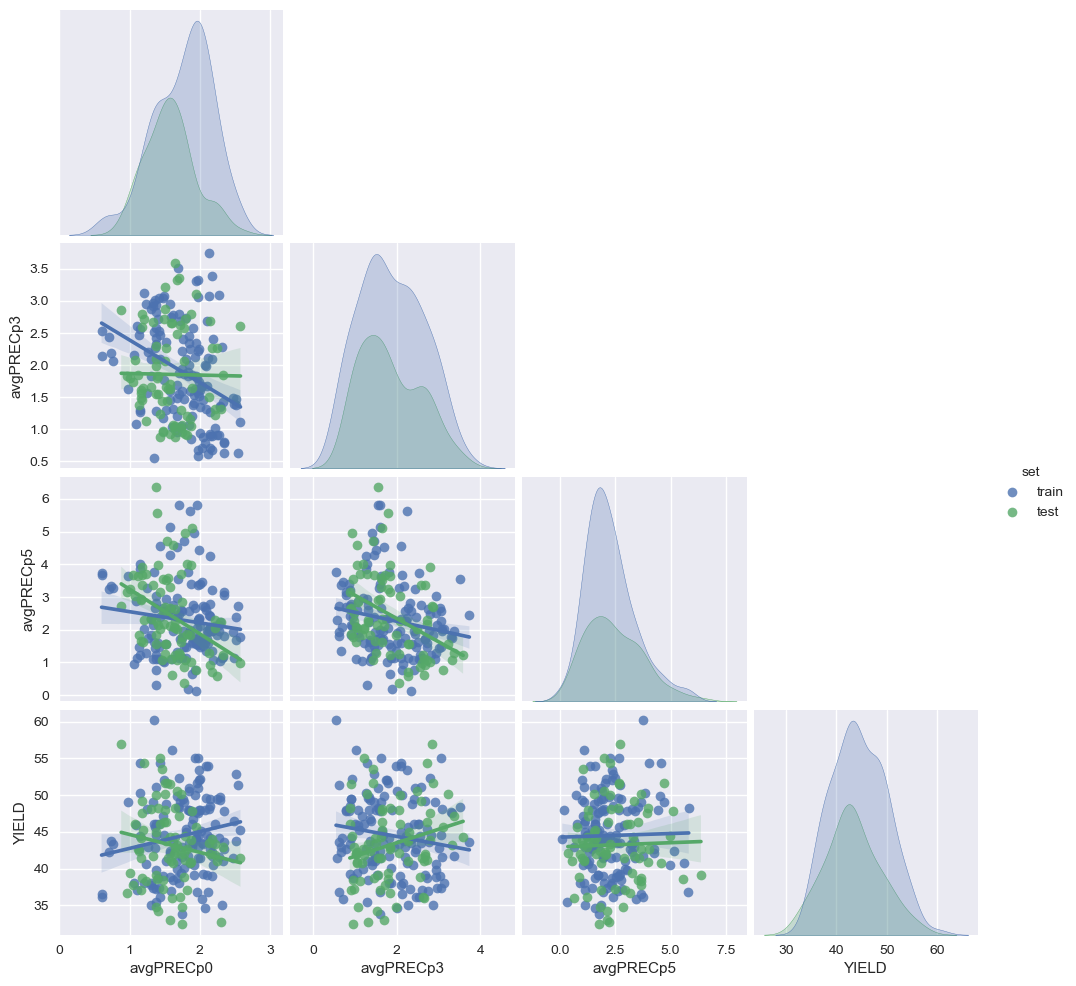

In [13]:
sns.pairplot(full.loc[:,['avgPRECp0', 'avgPRECp3', 'avgPRECp5', 'YIELD','set']], 
             hue = 'set',
             kind = 'reg',
             corner = True)

>   - Comment on the two visualizations produced in this exercise.

Regarding the scatter plot between yield and average FAPAR in periods p2 and p4:
- It seems that for avgFAPARp2 (fraction of absorbed photosynthetically active radiation in vegetative phase) there is a sliglthy negative relation between the yield and this varialbe both in the train and test datasets. that looks against the logical argument that the plants needs more radiation to growth more, specially in this phase when the plant is absorbing radiation to growth in leaves and steams. 
- On the other hand, avgFAPARp4 (Fraction of Absorbed Photosynthetically Active Radiation in yield foration phase) shows a negative relation between the yield and the variable for the train dataset and a positive relation in the test dataset. that could be because since the split of train and test in not random but considering different years. the test set could have specific years when other variables could be affecting this trend, for instance the potato variety. Different varieties have different partitioning indices and that could be affeting the final yield trend.

Regarding the scatter plot between yield and average precipitation in periods p0, p3 and p5:
- It seems that the average preipitation is not strongly correlated with the final yield. we can see a weak positive correlation for train dataset in phase 0 (pre-planting window), and test dataset for phase 3 (flowering phase) and negative for test and train for the same periods. in period 5 (harvest window) it seems there is not a correlation.
- This is logical sine we are looking the average value and the final yield probably is more influenced by daily preipitation amounts, maybe some year rained in a critial moment of the plant development and that decreased the yield. Or other year, maybe rained just when the plant needed water and in that way we can see higher yields.

> #### Question 1.5 (Optional) 
> Continue exploring the data.

C:\Users\mdomi\AppData\Local\Temp\ipykernel_18204\4094156065.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = full.iloc[:,2:].corr()


<Axes: >

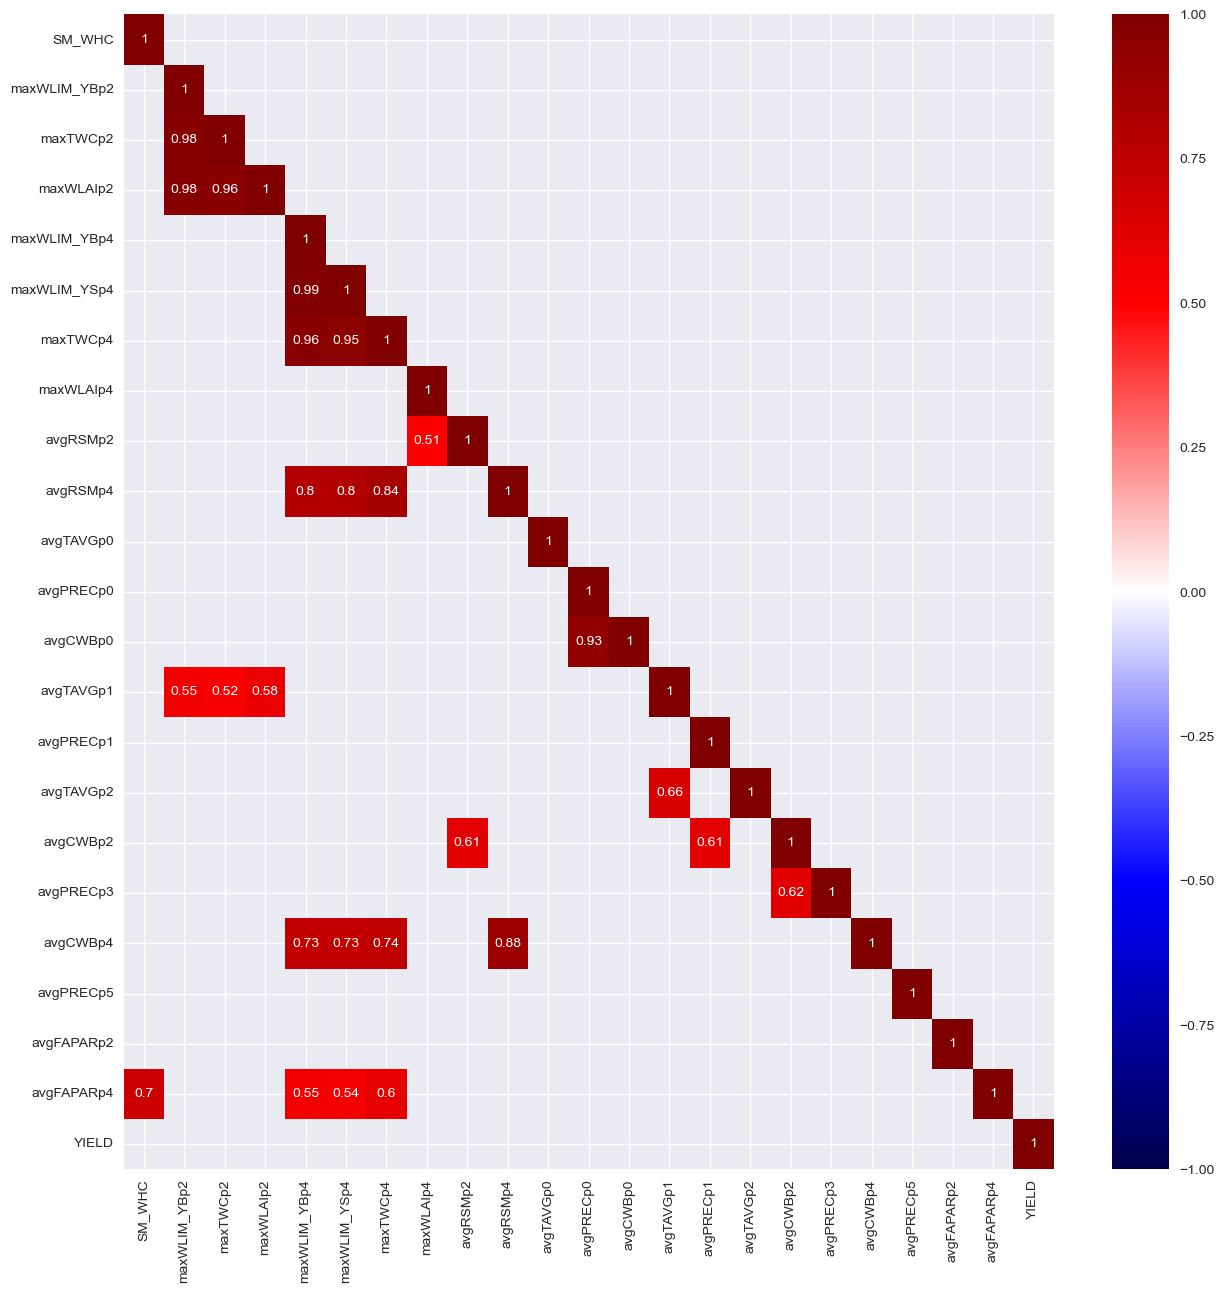

In [14]:
plt.figure(figsize = (15,15))

cor = full.iloc[:,2:].corr()
cor = pd.DataFrame(np.tril(cor.values), index = cor.index, columns = cor.columns)

sns.heatmap(cor[np.abs(cor) > 0.5], 
            vmin = -1,
            vmax = 1,
            cmap = 'seismic', 
            annot = True)

> provide a brief summary of what you discover.

It seems that variables with high correlation values (p >= 0.5) are  mainly positively correlated. that could be becauase some of the variables represent environmental variables, for instance temperature, precipitation, and transpiration. Normally (before reaching a threshold) this type of varialbes increases the plant growth, so we can see high correlation with plant growth variables, for instance leaf area index related variables.

Looking at the correlation figure, we can notice that some of the features are correlated between them. some are logical, for instane maxTWCp2 which represents the sum of water limited transpiration in period 2 (vegetative phase) with maxWLIM_YBp2 which represents water-limited dry weight biomass. This probably is because if a plant traspires more (at higher TWC values the plant dry biomass will increase) the dry weight will increase. Also the relation maxWLAIp2 with ax TWCp2 is quite logical since more leaf area index implies more transpiration if there is not water stress.

Other relations look less intuitive, for instance avgFAPARp4 with SM_WHC. Since SM_WHC is fixed in function of the soil type probably the avgFAPARp4 just fitted with the soil data without a explainable reason. Probably in this case it is a spurious correlation.

## Linear regression

$$ YIELD = \sum\big(\beta_i \cdot X_i\big)+ \beta_0 $$

### Exercise 2: Linear models

First, remove from your training and test data, the identifier columns, i.e. region name and year.

In [15]:
X_train = train.drop(columns=["IDREGION","FYEAR",'YIELD'])
y_train = train['YIELD']

X_test = test.drop(columns=["IDREGION","FYEAR",'YIELD'])
y_test = test['YIELD']

> #### Question 2.1
> Train a linear model with your training data, using the function `smf.ols(...).fit()`

In [16]:
# Create a formula string
formula = 'YIELD ~ ' + '+'.join(X_train.columns)
# Fit the model
mlm_fit = smf.ols(formula=formula, data=train).fit()
print(mlm_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  YIELD   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     8.761
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           3.82e-16
Time:                        22:21:36   Log-Likelihood:                -374.72
No. Observations:                 143   AIC:                             795.4
Df Residuals:                     120   BIC:                             863.6
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       43.2900     14.542      2.977   

In [17]:
mlm_fit.pvalues[mlm_fit.pvalues < 0.05]

Intercept       3.523979e-03
maxWLIM_YBp2    1.588906e-02
maxTWCp2        4.600450e-02
maxTWCp4        9.272271e-09
maxWLAIp4       1.413903e-02
avgTAVGp0       5.080849e-06
avgPRECp0       1.721530e-03
avgCWBp0        5.577055e-03
avgTAVGp1       3.967409e-02
avgPRECp5       5.487635e-03
avgFAPARp2      1.191459e-05
dtype: float64

The linear regression model fitted explains the variation in the Yield variable in a decent way ($adjusted R^2 = 0.546$) using 22 variables. However, some of the variables do not show a significant association with Yield ($p_{value} > 0.05$) and could then be removed from the model. 

> #### Question 2.2
>  Check the coefficients of the model.  Which are the most significant? What does the signs of the coefficients mean? 

**Summarized parameters:**

| Parameter | p-value | sign |
|-----------| ------- | ---- | 
maxTWCp4    | 9.27e-09 |+|  
avgTAVGp0   |  5.08e-06|+| 
avgFAPARp2  |  1.19e-05|-| 
avgPRECp0   |  1.72e-03|-|  
avgPRECp5   |  5.49e-03|+| 
avgCWBp0    |  5.58e-03|+| 
maxWLAIp4   |  1.41e-02|-| 
maxWLIM_YBp2|  1.59e-02|-| 
avgTAVGp1   |  3.97e-02|+| 
maxTWCp2    |  4.60e-02|+|

1. The most signifcant parameters are maxTWCp4 and avgTAVGp0, since they have the lowest p-values.
2. The sign in the coefficient shows the direction of the influence of predictor in predicted values. In the pecific case of the most significant parameters:
      - For an unitary **increase** of maximum total water content the yield will **increase** in 2.81 ton/ha
      -  For an unitary **increase** of average temperature the yield will **increase** in 3.54 ton/ha

> #### Question 2.3
>  What is the $R^2$  reported for training? 

Adjusted training $R^2$ = 0.55

> #### Question 2.4
> Apply the linear model for making predictions with the test data. Report RMSE, MAE and R2 metrics for both training and test sets. 

In [18]:
y_pred = mlm_fit.predict(X_test)
y_pred_tr = mlm_fit.predict(X_train)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

MAE = mean_absolute_error(y_train, y_pred_tr)
RMSE = np.sqrt(mean_squared_error(y_train, y_pred_tr))
R2 = r2_score(y_train, y_pred_tr)

print('train MAE:', MAE, ' \ntrain RMSE:', RMSE, '\ntrain R2:', R2,'\n\n')

MAE = mean_absolute_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)

print('test MAE:', MAE, ' \ntest RMSE:', RMSE, '\ntest R2:', R2)

train MAE: 2.656921910377113  
train RMSE: 3.3250404276524903 
train R2: 0.616303866005021 


test MAE: 5.326556401795499  
test RMSE: 6.336382794407347 
test R2: -0.38138781998055094


>  - Comment your results below.

MAE shows that on average the model prediction distance to the true value of the test dataset is 5.32 ton/ha.

RMSE shows the squared root of the average of the squared value of the errors (distances between predicted and true). In average this shows there is an error of predictions of 6.34 ton/ha.

Since R2 is negative for the test dataset, the model is predicting the yield worse than the worst least square predictor (an horizontal hyperplane far from the mean value of yield) (https://en.wikipedia.org/wiki/Coefficient_of_determination).

$$ R^2 = 1 - \frac{SSR}{SST}$$

Finally, we suggest that the bad results obtained for this model are due to over-fitting by including too many predictors.

> #### Question 2.5. 
> Visualize your model predictions in the test set vs. the observed values.


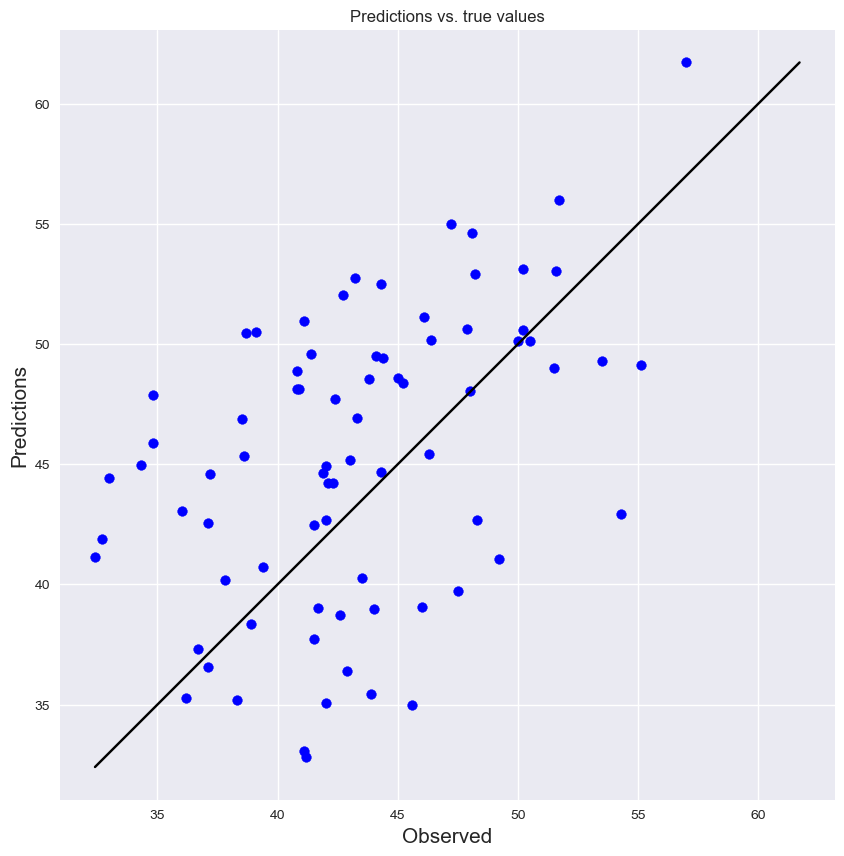

In [19]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c = 'b')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'k')
plt.xlabel('Observed', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title('Predictions vs. true values')
plt.show()

## K-Nearest Neighbors Regression

### Exercise 3: K-Nearest Neighbors for regression

> #### Question 3.1

> What value for K would you guess being reasonable? 

In theory a good aproximation to a good K value is using the square root of 'n', in this case 12 but doing that that MAE is equal to 4.19, MSE is 27.47 and $R^2$ is equal to 0.05. Due to this, we decided to use a smaller K equal to 3 in order to use a not too small K to avoid underfitting (high bias and low variance) nor a high K to avoid overfitting (low bias and high variance).

Using K=3 we got a MAE equal to 4.13, and MSE equal to 25.67 and a $R^2$ equal to 0.12.

> Train a KNN regression model for this value, and evaluate its performance in the test set using the metrics used for the linear model.

In [20]:
knn_fit = KNeighborsRegressor(n_neighbors=3).fit(X_train, y_train)

y_pred_knn = knn_fit.predict(X_test)

print('MAE: ', mean_absolute_error(y_test, y_pred_knn))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_knn)))
print('R^2: ', r2_score(y_test, y_pred_knn))

MAE:  4.1307359307359315
RMSE:  5.066897351777396
R^2:  0.11668211743348733


>  Comment the scores of the KNN model and compare to the ones previously obtained by the linear model.

| Method                  | MAE      | RMSE | $R^2$|
|-------------------------|----------|-----|------|
|Linear regression        | 5.32     |6.34|-0.38 |
|kNN (k=3)                | 4.12     |5.01| 0.11 |

Using kNN method to predict potatoe yield improves a bit the results. MAE, RMSE, and $R^2$ improved slightly. The most relevant improvement was the $R^2$ because it changed from a negative value to a positive, indicating a correlation between observed and predicted data but still a $R^2$ equal to 0.11 is not a good enough to for instance use this model for resources management. 

> #### Question 3.2
Run the KNN by using as training samples the first 110 samples of the training set and the remaining 33 samples of the training set as validation set.   **Do not use the test set here, otherwise you will bias your final results!** Pick the best k, based on the performance on the validation set. 

In [21]:
# Little help with slicing the dataset :)
X_train110 = X_train.iloc[:110]
y_train110 = y_train.iloc[:110]

X_validation = X_train.iloc[110:]
y_validation = y_train.iloc[110:]

,K,MAE,MSE,R^2
0,1.0,6.427273,68.637273,-2.660326
1,2.0,6.533333,63.165303,-2.368514
2,3.0,6.419192,59.103535,-2.151906
3,4.0,6.518939,60.559678,-2.229560
4,5.0,6.403030,57.313564,-2.056449
5,6.0,6.457071,58.838106,-2.137751
6,7.0,6.452381,56.776988,-2.027835
7,8.0,6.560227,58.079560,-2.097299
8,9.0,6.586195,57.261680,-2.053683
9,10.0,6.615455,58.225579,-2.105086


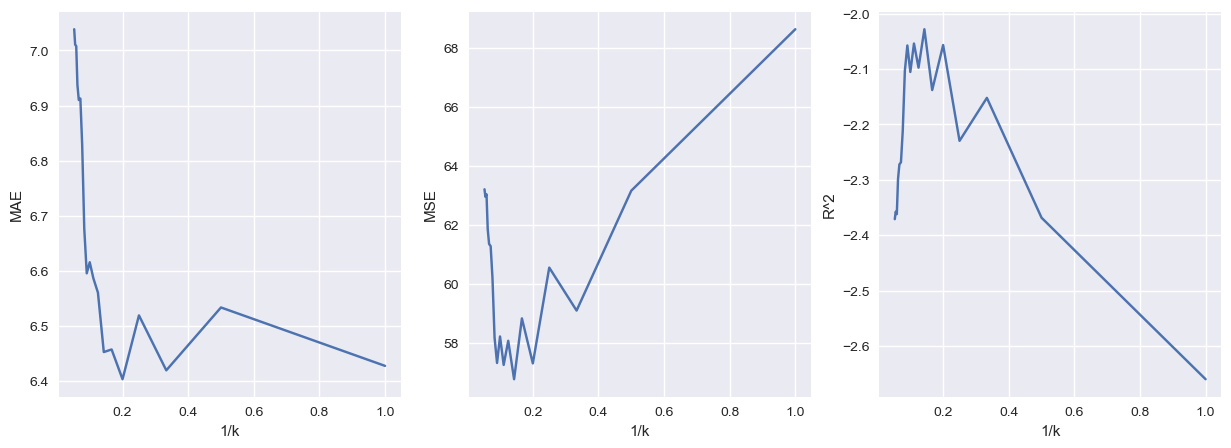

In [22]:
k = np.arange(1, 20, 1)

MAE_knn = []
MSE_knn = []
R2_knn = []

for i in k:
    knn_fit = KNeighborsRegressor(n_neighbors=i).fit(X_train110, y_train110)

    y_pred_knn = knn_fit.predict(X_validation)

    MAE_knn.append(mean_absolute_error(y_validation, y_pred_knn))
    MSE_knn.append(mean_squared_error(y_validation, y_pred_knn))
    R2_knn.append(r2_score(y_validation, y_pred_knn))
    
fig, ax = plt.subplots(1, 3, figsize = (15,5))
ax[0].plot(1/k, MAE_knn)
ax[0].set_ylabel('MAE')
ax[0].set_xlabel('1/k')
ax[1].plot(1/k, MSE_knn)
ax[1].set_ylabel('MSE')
ax[1].set_xlabel('1/k')
ax[2].plot(1/k, R2_knn)
ax[2].set_ylabel('R^2')
ax[2].set_xlabel('1/k')

k_metrics = pd.DataFrame([k,MAE_knn, MSE_knn, R2_knn]).T
k_metrics.columns = ['K','MAE','MSE','R^2']
k_metrics

>   - 3.2a. What range of values would be suitable for K in this problem?  

A suitable range could be between 1 and 20. 
<br>
Our best k was between 5 and 7

>   - 3.2b. Report your best k, your metrics and comment.  

The best metrics are achieved with K = 5 anf K = 7. This indicates that the dataset needs a relatively flexible model (small k) to perform the best.
<br>
The values of the metrics and the k's with which they were obtained are presented below:

| metric| best k | value  | 
| ----- | ------ | ------ |
|  MAE  |    5   |   6.4  |
|  MSE  |    7   |  56.77 |
| $R^2$ |    7   | -2.03  |

> #### Question 3.3
> Once you identified a good value for k, train your model using the full training set and evaluate its performance for the test set. 

In [23]:
knn_fit = KNeighborsRegressor(n_neighbors=5).fit(X_train, y_train)

y_pred_knn = knn_fit.predict(X_test)

> ##### Question 3.3a
> - Report the evaluation metrics, and compare with linear regression.

In [24]:
print('MAE: ', mean_absolute_error(y_test, y_pred_knn))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_knn)))
print('R^2: ', r2_score(y_test, y_pred_knn))

MAE:  4.326753246753248
RMSE:  5.276051258575574
R^2:  0.04225295044008037


| Method                  | MAE      | RMSE | $R^2$|
|-------------------------|----------|-----|------|
|Linear regression        | 5.32     |6.34|-0.38 |
|kNN (k=5)                | 4.32     |5.27| 0.04 |
|kNN (k=7)                | 4.30     |5.34| 0.01 |

kNN methods work better than linear regression using either 5 or 7 as 'k'. The mean absolute error is slighlty better than linear regression. The mean squared is also better using kNN. But looking at the $R^2$ (LR: -0.38, kNN (k=5): 0.04, kNN (k=7): 0.01) we can notice that even though using kNN is a bit better than just using the mean value none model is good enough to estimate the potato yields.

To sum up, tunning the 'k' value using a validation set improves a bit the performance of the regression but still the results are not that good to predict potato yield using this data set.

> ##### Question 3.3b 
> - Make a scatter plot of the predictions of the KNN and linear model against the observed yields. 


(30.93410197533773, 63.183858517907694, 30.93410197533773, 63.183858517907694)

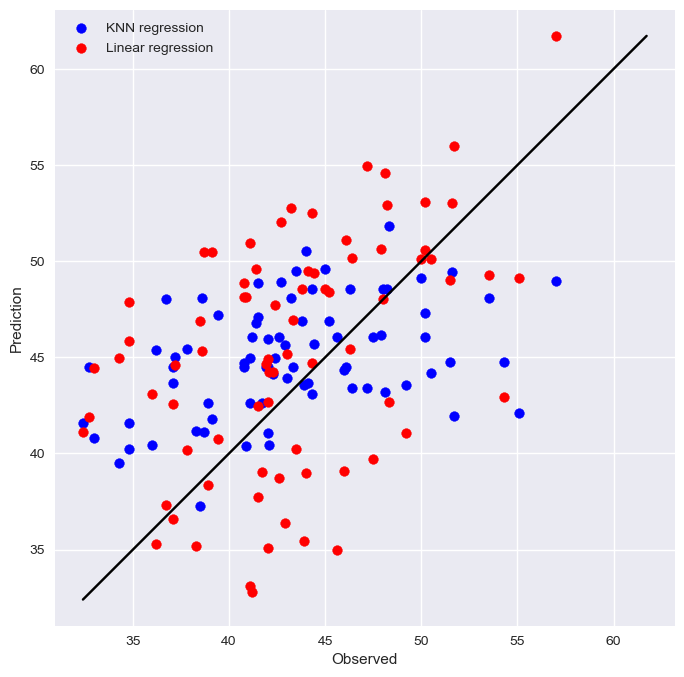

In [25]:
fig, ax = plt.subplots(1,figsize = (8,8))

plt.scatter(y_test,
            y_pred_knn,
            color = 'blue',
            label = 'KNN regression'
           )

plt.plot([np.min([y_test, y_pred]), np.max([y_test, y_pred])],
         [np.min([y_test, y_pred]), np.max([y_test, y_pred])],
         color = 'k'
        )

plt.scatter(y_test,
            y_pred,
            color = 'red',
            label = 'Linear regression'
           )

plt.xlabel('Observed')
plt.ylabel('Prediction')

plt.legend()

plt.axis('equal')

> ##### Question 3.3c  (optional)
> 
> Visualize a boxplot of the errors of the KNN and linear models. 

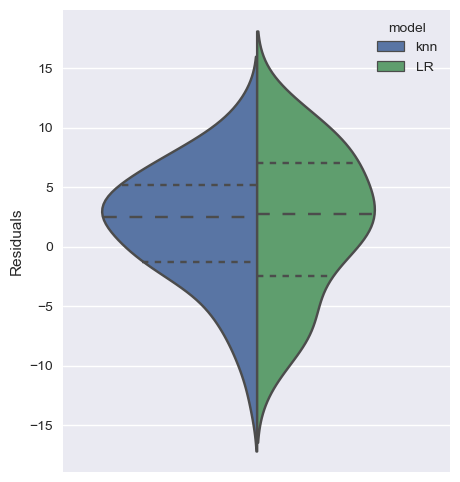

In [26]:
residuals_knn = y_pred_knn - y_test
residuals_linear = y_pred - y_test

df_resid = pd.DataFrame([residuals_knn, residuals_linear], index = ['KNN','LR']).T

df = pd.DataFrame(pd.concat([residuals_knn, residuals_linear]))
df['model'] = np.ones(len(df))
df['model'].iloc[:len(residuals_knn)] = 'knn'
df['model'].iloc[len(residuals_knn):] = 'LR'

plt.figure(figsize = (5,6))
sns.violinplot(data = df, x = np.ones(len(df)),
               y = 0,
               hue = 'model',
               inner = 'quartile',
               split = True)

plt.ylabel('Residuals')
plt.xticks([])
plt.show()

> What do you observe?

As it can be seen in the violin plot, the residuals calculated for the KNN regression have a mean value closer to 0 and have a smaller spread (variance) than the residuals for the linear regression. Guided by this plot, we would then prefer to use a KNN regression.

## Spatial visualization

### Exercise 4: Spatial visualization of errors (Optional)

> ## Question 4.1. 
> - For both the linear and the KNN models, visualize in a map their errors for year 2012. 

Text(0.5, 1.0, 'KNN error for crop\nyield estimation in the Netherlands in 2012')

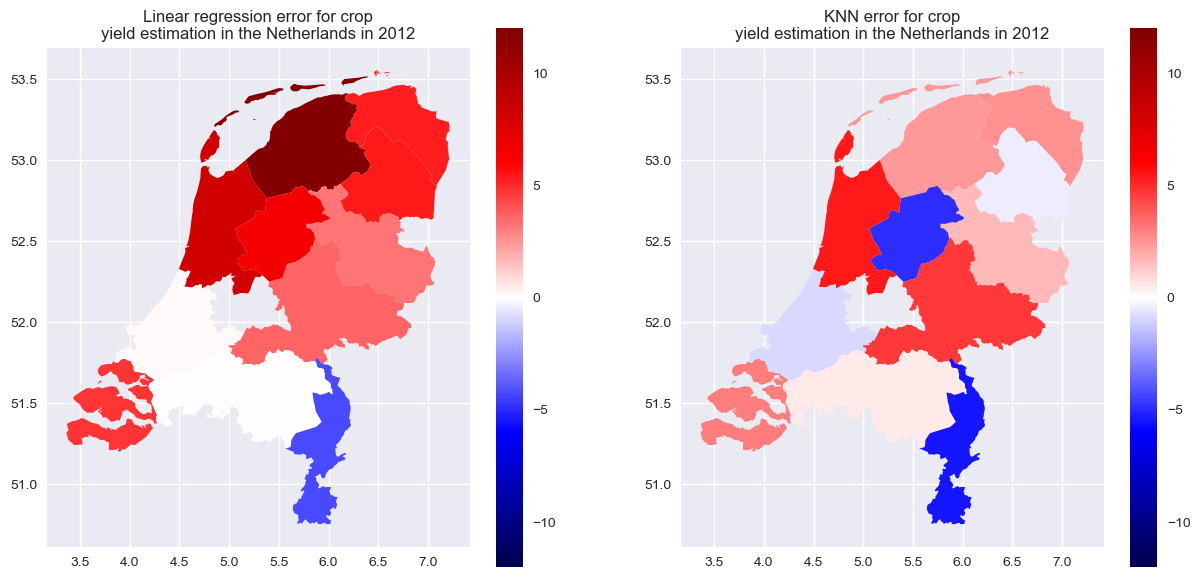

In [27]:
df_test_error = pd.concat([test, df_resid], axis = 1)

nuts2 = gpd.read_file('https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_01M_2016_4326_LEVL_2.geojson') 
yield_nuts2 = pd.merge(nuts2, df_test_error, left_on = "NUTS_ID", right_on = "IDREGION")
yield_nuts2_2012 = yield_nuts2[yield_nuts2["FYEAR"]==2012]

fig, ax = plt.subplots(1, 2, figsize  = (15, 7))

yield_nuts2_2012.plot(yield_nuts2_2012["LR"], legend=True, ax=ax[0], vmin=-12, vmax = 12, cmap="seismic")
ax[0].set_title("Linear regression error for crop\nyield estimation in the Netherlands in 2012", fontsize=12)

yield_nuts2_2012.plot(yield_nuts2_2012["KNN"], legend=True, ax=ax[1], vmin = -12, vmax = 12, cmap="seismic")
ax[1].set_title("KNN error for crop\nyield estimation in the Netherlands in 2012", fontsize=12)

 > -  Comment on your visualizations

As it was suggested by the distribution of residuals in the violin plot, the error estimation of crop yield per region has higher overall values in the linear regression model (Darker colors) than in the KNN regression (lighter colors). 